# __Data visualisation__

What follow in the next couple of notebooks is the optimisation of a time series forecast model. Hence, we will only use the train set for that, before finally testing whatever we have found and optimised on a test set.

In [1]:
import datetime as dt
import os

from random import seed, random

import warnings
warnings.simplefilter('ignore') # ignore warnings

from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns

import pylab
pylab.rcParams['figure.figsize'] = (7, 4)  # fixes the figure size

In [32]:
df = pd.read_pickle('../../data/train.pkl')
df.drop(columns=['Price'], inplace=True)
df.head()

,CO2E_EMISSIONS_FACTOR
2009-07-01 04:00:00,0.991217
2009-07-01 04:05:00,0.000000
2009-07-01 04:10:00,0.000000
2009-07-01 04:15:00,0.991217
2009-07-01 04:20:00,1.025701


In [4]:
df.isnull().any()

CO2E_EMISSIONS_FACTOR    False
dtype: bool

### __Simple time series plot__

Due to the massive size of the dataset, we only plot out a 48 h section of it:

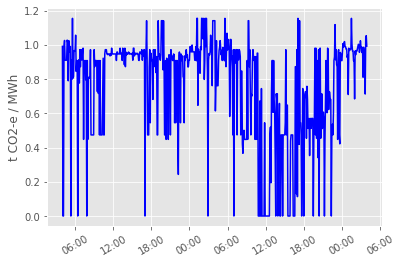

In [5]:
fig = sns.lineplot(df.index[:576], df['CO2E_EMISSIONS_FACTOR'].iloc[:576], color='blue')
fig.set_ylabel("t CO2-e / MWh")

date_format = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(date_format)

for i in fig.get_xticklabels():
    i.set_rotation(30)

sns.set_style("whitegrid")

This looks a bit messy and as if it only gives us little insights. Let's have look at the data on a greater scale. But given the fact we work with a 10 years dataset of a 5min granularity, we might want to do some resampling as in the following.

### __Plotting grouped time intervals__

In order to decrease the size of our dataset for its plotting, we use the .resample() method with option "M", averaging our data for each month

Check out 'DateOffset objects here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects'

In [6]:
df_resample = df.resample("M").mean() 

<table style="display: inline-block">
    <caption style="text-align: center"><strong>TIME SERIES OFFSET ALIASES</strong></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>B</td><td>business day frequency</td></tr>
<tr><td>C</td><td>custom business day frequency (experimental)</td></tr>
<tr><td>D</td><td>calendar day frequency</td></tr>
<tr><td>W</td><td>weekly frequency</td></tr>
<tr><td>M</td><td>month end frequency</td></tr>
<tr><td>SM</td><td>semi-month end frequency (15th and end of month)</td></tr>
<tr><td>BM</td><td>business month end frequency</td></tr>
<tr><td>CBM</td><td>custom business month end frequency</td></tr>
<tr><td>MS</td><td>month start frequency</td></tr>
<tr><td>SMS</td><td>semi-month start frequency (1st and 15th)</td></tr>
<tr><td>BMS</td><td>business month start frequency</td></tr>
<tr><td>CBMS</td><td>custom business month start frequency</td></tr>
<tr><td>Q</td><td>quarter end frequency</td></tr>
<tr><td></td><td><font color=white>intentionally left blank</font></td></tr></table>

<table style="display: inline-block; margin-left: 40px">
<caption style="text-align: center"></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>BQ</td><td>business quarter endfrequency</td></tr>
<tr><td>QS</td><td>quarter start frequency</td></tr>
<tr><td>BQS</td><td>business quarter start frequency</td></tr>
<tr><td>A</td><td>year end frequency</td></tr>
<tr><td>BA</td><td>business year end frequency</td></tr>
<tr><td>AS</td><td>year start frequency</td></tr>
<tr><td>BAS</td><td>business year start frequency</td></tr>
<tr><td>BH</td><td>business hour frequency</td></tr>
<tr><td>H</td><td>hourly frequency</td></tr>
<tr><td>T, min</td><td>minutely frequency</td></tr>
<tr><td>S</td><td>secondly frequency</td></tr>
<tr><td>L, ms</td><td>milliseconds</td></tr>
<tr><td>U, us</td><td>microseconds</td></tr>
<tr><td>N</td><td>nanoseconds</td></tr></table>

In [7]:
df_resample.head()

,CO2E_EMISSIONS_FACTOR
2009-07-31,0.712658
2009-08-31,0.746656
2009-09-30,0.713189
2009-10-31,0.640791
2009-11-30,0.636747


Let's plot out our resampled data:

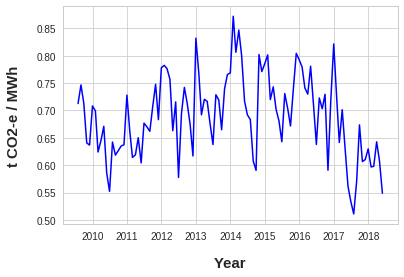

In [8]:
fig = plt.plot_date(df_resample.index, df_resample['CO2E_EMISSIONS_FACTOR'], linestyle='solid', marker=None, color='blue')

plt.xlabel("Year", labelpad=15, fontsize=15, fontweight='bold')
plt.ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')

sns.set_style('whitegrid')
plt.style.use('seaborn')

### __Anything more than randomness? -> decompose__

From the above plots it is difficult to find any clear patterns. 

Let's explore what other methods we can use and what other analyses can be performed to get a clearer picture of our data.

The `statsmodels` package has functionality to decompose our time series using a naive, moving average approach:

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

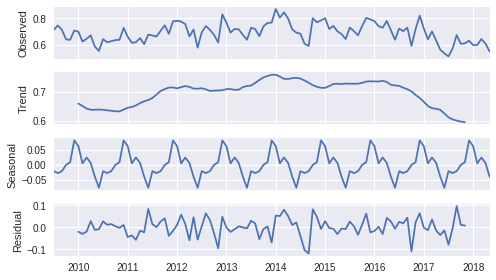

In [10]:
df_decomposed = seasonal_decompose(df_resample['CO2E_EMISSIONS_FACTOR'], model='additive')
#we well learn about additive and multiplicative models in notebook 07
pylab.rcParams['figure.figsize'] = (7, 4)
df_decomposed.plot();

### __Anything more than randomness? -> check for random walk behaviour__

Any time series with a random walk behaviour is - as the name suggests - a random dataset whose association to a timestamp do not provide any useful insights. In order for it to be useful to examine our dataframe for time features, we should be able to exclude the possibility for our dataset to be a random walk.

A random walk is a time series, of which an obeserved value $y_t$ simply depends on its previous value $y_{t-1}$ and an error $\epsilon_t$, rendering the relation betweem timestap and target value random.

__Random walk:__
<br/>
$y_t=y_{t-1}+\epsilon_t$
<br/>
<br/>

In [11]:
import numpy as np

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

Lets sample a random walk:

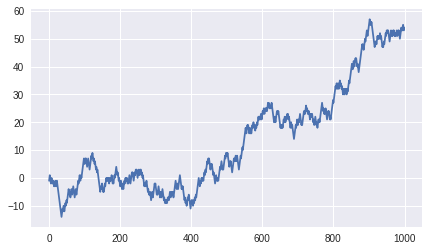

In [12]:
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)

for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
    
pyplot.plot(random_walk)
pyplot.show()

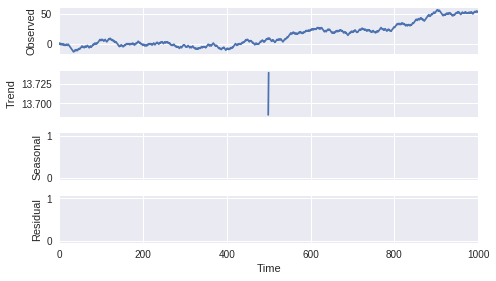

In [13]:
test = seasonal_decompose(random_walk, freq=998)
pylab.rcParams['figure.figsize'] = (7, 4)
test.plot();

__Compare this with the seasonal decomposition of our dataset.__

#### __Autocorrelation plots of random walks__

Other than by checking our dataset for its seasonal decomposition, we can compare the autocorrelations functions of our dataset and the one of a random walk, as the latter comes with a very specific trajectory.

But first, let's dive into what autocorrelation functions are.

#### __Autocorrelation:__

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

Autocorrelation is a key tool in time series.  It is particularly useful in identifying seasonality, which can inform which lagged values to include as features (more on lagging later).

### __Random walk acf__

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

The random walk acf features a slow and linear decrease of the acf components with increasing lags.  

The y-axis reflects the respective correlation which stem from the comparison of $y_t$ and $y_{t-1}$, $y_{t-2}$, ..., $y_{t - lags}$, while the lags are shown on the x-axis.

__It is characteristic for a random walk acf to decay slowly in a linear fashion.__

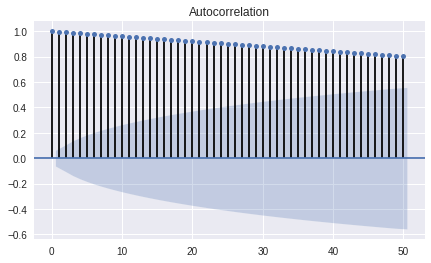

In [15]:
_ = plot_acf(random_walk, lags=50)

### __Autocorrelation of our dataset__

We are working with a pretty massive dataset of which the calculation of the acf becomes pretty time-consuming. 

Therefore, we will only examine a section of our dataset.

In [16]:
df_acf = df[df.index > dt.datetime(2016,1,1,0,0,0)]
print(df.index.min())
df_acf.index.max()

2009-07-01 04:00:00


Timestamp('2018-05-31 23:55:00')

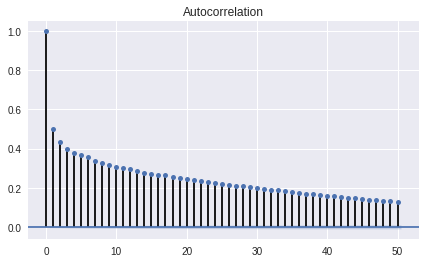

In [17]:
plot_acf(df_acf, lags=50);

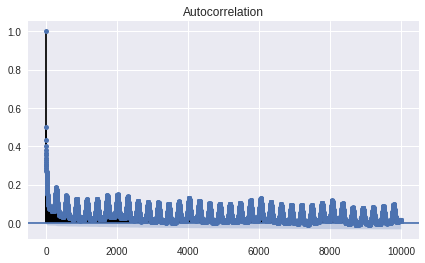

In [18]:
plot_acf(df_acf, lags=10000);

Our dataset features an exponential decay and therefore clearly differs from a random walk. Moreover, the latter plot clearly shows seasonality - daily and weekly.

### __Anything more than randomness? -> Autocorrelation of differenced data__

A dataset can be processed by always subtracting a value $y_t$ from its preceding value $y_{t-1}$. That action is called _differencing_, which we have already seen.

#### __Acf of a differenced random walk__

In case of a random walk, differenced data reflect nothing but the stochastic error:
<br/>
<br/>
$y_t - y_{t-1} = \epsilon_t$

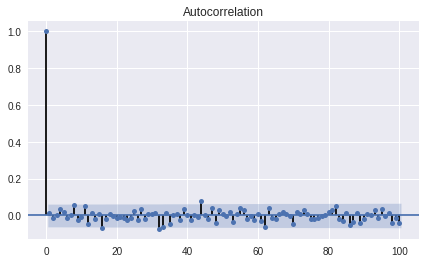

In [19]:
# take difference
diff = list()
for i in range(1, len(random_walk)):
	value = random_walk[i] - random_walk[i - 1]
	diff.append(value)
    
plot_acf(diff, lags=100);

### __Acf of our dataset__

Let's difference the CO2 column of our dataset. In pandas, this can be done with the .shift() method.

In [21]:
df_acf['differenced'] = df_acf["CO2E_EMISSIONS_FACTOR"] - df_acf["CO2E_EMISSIONS_FACTOR"].shift(1)
df_acf.head(7)

,CO2E_EMISSIONS_FACTOR,differenced
2016-01-01 00:05:00,0.681150,NaN
2016-01-01 00:10:00,0.681150,0.000000
2016-01-01 00:15:00,0.000000,-0.681150
2016-01-01 00:20:00,0.000000,0.000000
2016-01-01 00:25:00,0.000000,0.000000
2016-01-01 00:30:00,0.910143,0.910143
2016-01-01 00:35:00,0.681150,-0.228993


In [23]:
#  note that differencing causes one NaN value in our dataset
df_acf[df_acf.differenced.isna()]

,CO2E_EMISSIONS_FACTOR,differenced
2016-01-01 00:05:00,0.68115,NaN


In [24]:
#we need to delete the NaN value in order to plot our acf
df_acf.dropna(inplace=True)
df_acf[df_acf.differenced.isna()]

,CO2E_EMISSIONS_FACTOR,differenced


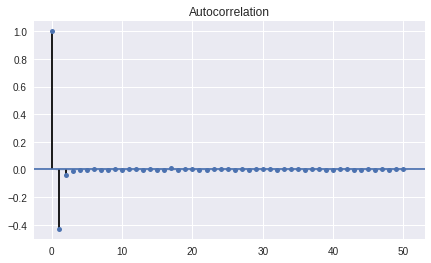

In [25]:
plot_acf(df_acf.differenced, lags=50);

__Also here, the acf of our dataset looks different from the one of the random walk. Further interpretations are not of any concern here.__

## __Selection of relevant time features for training__

One common way to identify relevant time features for predictions is to plot our target averaged over different time periods. We do this with the .groupby() method making use of our DateTimeIndex.

Note: this is a common way to identify time features, but it is not exhaustive. Metrics exist to check for that quantitatively. We will see one of them later today.

In [26]:
group_year = df.groupby(df.index.year).mean()
group_quarter = df.groupby(df.index.quarter).mean()
group_month = df.groupby(df.index.month).mean()
group_week = df.groupby(df.index.week).mean()
group_weekday = df.groupby(df.index.weekday).mean()
group_day = df.groupby(df.index.day).mean()
group_hour = df.groupby(df.index.hour).mean()
group_minute = df.groupby(df.index.minute).mean()

#quarter: Quarter of the date: Jan-Mar = 1, Apr-Jun = 2, etc.

In [27]:
time_periods = {"year":group_year,"quarter":group_quarter, "month":group_month, "week":group_week,\
                "weekday":group_weekday,"day":group_day, "hour":group_hour, "minute":group_minute}

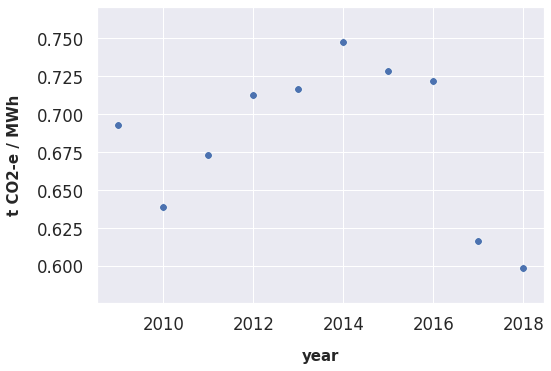

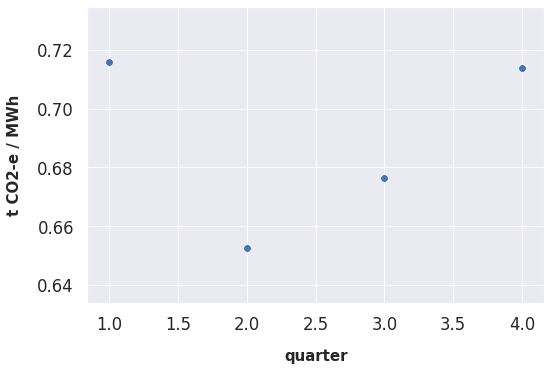

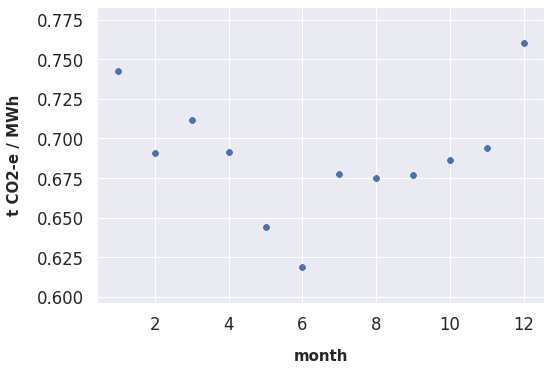

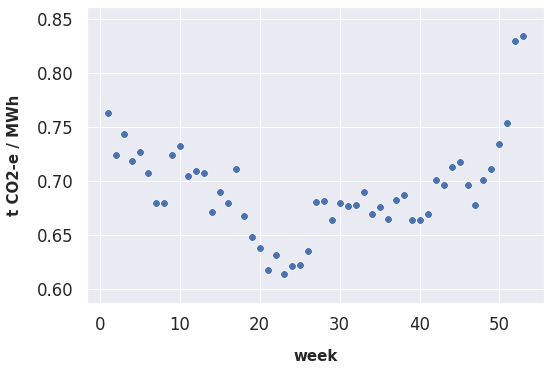

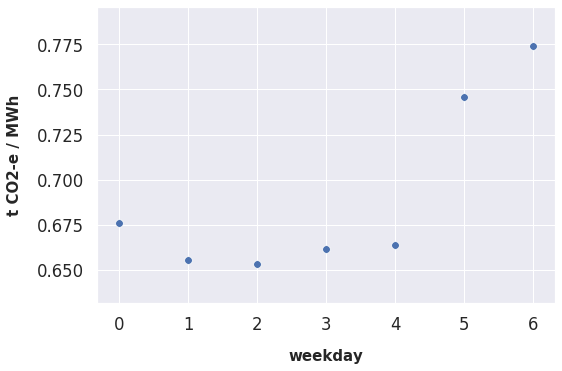

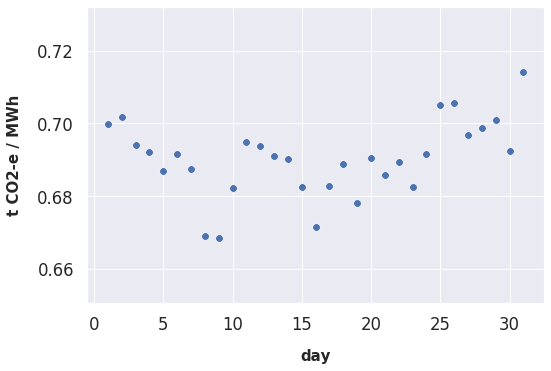

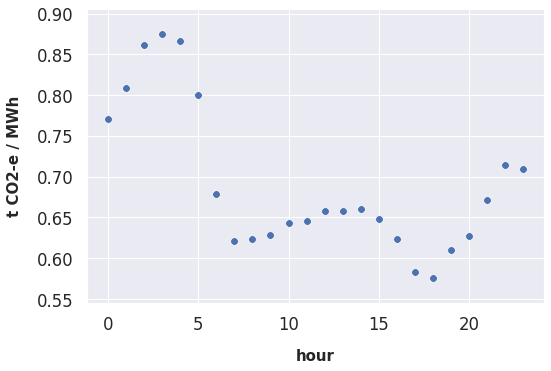

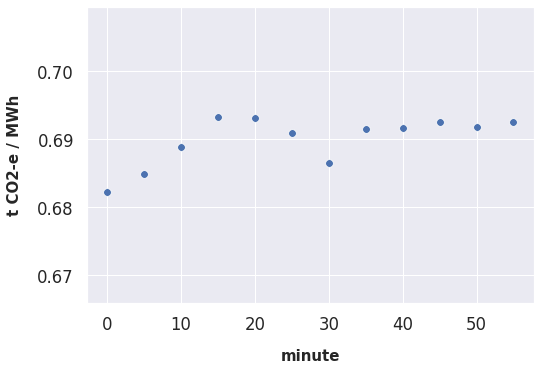

<Figure size 576x396 with 0 Axes>

In [31]:
for i in time_periods:
    fig = sns.scatterplot(time_periods[i].index, time_periods[i]['CO2E_EMISSIONS_FACTOR'], s=60)
    
    fig.set_xlabel(i, labelpad=15, fontsize=15, fontweight='bold')
    fig.set_ylabel("t CO2-e / MWh", labelpad=15, fontsize=15, fontweight='bold')
    
    plt.style.use('seaborn')
    sns.set(font_scale=1.5)
    plt.tight_layout()
    
    plt.figure()

A visual inspection of the time features returns to us the following relevant ones: year, month, weekday/weekend, hour of day, minute of hour 